In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import math
import torch
from torch.utils import model_zoo
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import time
from utilities import sampling, one_hot_encoding, curtail, get_training_data, load_data, data_split, dianostic_plots, pad_for_detector
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
if use_cuda:
    print(torch.cuda.get_device_name(0))

Tesla K80


In [3]:
data_x = pickle.load(open('../../../../temp/buffers/ss_samples/train_x.data', 'rb'))
data_y = pickle.load(open('../../../../temp/buffers/ss_samples/train_y.data', 'rb'))
train_x, train_y, val_x, val_y = data_split(data_x, data_y, seed = 157)
train_x, val_x = pad_for_detector(train_x, 10), pad_for_detector(val_x, 10)

5016 (4013, 1000, 4) (4013,) (1003, 1000, 4) (1003,)


In [4]:
train_x, val_x = torch.from_numpy(train_x).float(), torch.from_numpy(val_x).float()
train_y, val_y = torch.from_numpy(train_y).float(), torch.from_numpy(val_y).float()

# Convert data format from channel_last to channer_first
N, L, C = train_x.shape
n, l, _ = val_x.shape
train_x = train_x.reshape(N, C, L)
val_x = val_x.reshape(n, C, l)

# Generate dataset for data loader
train_dataset = data.TensorDataset(train_x, train_y)
val_dataset = data.TensorDataset(val_x, val_y)

In [5]:
class HybridNet(nn.Module):
    
    def __init__(self, pesudo_input, num_filters, filter_size, rnn_size, fc_out, dp1, dp2, 
                 num_rnn_layers=1, rnn_dropout=0):
        super(HybridNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=4, out_channels=num_filters, kernel_size=filter_size)
        out = self.conv1(pesudo_input)
        out = nn.MaxPool1d(kernel_size=5, stride=5)(out)
        bs, seq_len, input_size = out.shape
        out = out.reshape(seq_len, bs, input_size)
        self.bi_lstm = nn.LSTM(input_size=input_size, hidden_size=rnn_size, num_layers=num_rnn_layers,
                              batch_first=True, dropout=rnn_dropout, bidirectional=True)
        out, _ = self.bi_lstm(out)
        #print(out.shape)
        seq_len, bs, output_size = out.shape
        out = out.reshape(bs, seq_len*output_size)
        self.fc1 = nn.Linear(seq_len*output_size, fc_out)
        self.fc2 = nn.Linear(fc_out, 1)
        self.p1 = dp1
        self.p2 = dp2
        
    def forward(self, seq):
        self.activation_seq = F.relu(self.conv1(seq))
        out = nn.MaxPool1d(kernel_size=5, stride=5)(self.activation_seq)
        out = nn.Dropout(p=self.p1)(out)
        
        #################################################################################
        # Input of LSTM layer should have shape (sequence_length, batch_size, input_size)
        #     - Sequence length here should be the length of activation after downsampling
        #     - Input size should be the number of filters
        #################################################################################
        bs, seq_len, input_size = out.shape
        #print('shape before lstm {}'.format(out.shape))
        out = out.reshape(seq_len, bs, input_size)
        #print('shape after reshapping before lstm {}'.format(out.shape))
        out, _ = self.bi_lstm(out)
        out = F.relu(out)
        
        #################################################################################
        # Need to flatten the sequence before feeding them into fully connected layer
        #################################################################################
        seq_len, bs, output_size = out.shape
        #print('shape after lstm {}'.format(out.shape))
        out = out.reshape(bs, seq_len*output_size)
        #print('shape after reshaping {}'.format(out.shape))
        out = nn.Dropout(p=self.p2)(out)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = torch.squeeze(out)
        return nn.Sigmoid()(out)

In [20]:
batch_size = 256
pesudo_input = torch.rand(batch_size, C, L, dtype=train_x.dtype)
hybrid_net = HybridNet(pesudo_input,
                       num_filters=15, 
                       filter_size=10, 
                       rnn_size=10, 
                       fc_out=20, 
                       dp1=0.6, dp2=0.7).to(device)

In [21]:
optimizers = {'adam': torch.optim.Adam(hybrid_net.parameters(), lr=1e-3),
              'rmsprop': torch.optim.RMSprop(hybrid_net.parameters(), lr=1e-4, weight_decay=0.1)}
config = {'epochs':200, 'device':device, 
          'opt': optimizers['rmsprop'],
          'criterion':nn.BCELoss(),
          'batch_size': batch_size,
          'log_interval':5}
C, L = train_x[0].shape

In [22]:
def train(model, train_dataset, val_dataset, config):
    # Unpack config
    epochs = config['epochs']
    device = config['device']
    optimizer = config['opt']
    criterion = config['criterion']
    log_interval = config['log_interval']
    batch_size = config['batch_size']
    
    def get_acc(y_hat, y):
        y_pred = np.where(y_hat >=0.5, 1, 0)
        return np.mean(y_pred == y)
    
    # Generate data loaders
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size)
    val_loader = data.DataLoader(val_dataset, batch_size=batch_size)
    total_train_steps = len(train_loader)
    total_val_steps = len(val_loader)
    
    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list = [], []
    print("Train on {} samples, validate on {} samples".format(len(train_dataset), len(val_dataset)))
    # Start training
    for epoch in range(1, epochs+1):
        train_loss_sum, train_acc_sum = 0, 0
        tic = time.time()
        model.train()
        for i, (batch, labels) in enumerate(train_loader):
            # Transfer data to GPU
            batch, labels = batch.to(device), labels.to(device)
            
            # Forward pass and calculating loss
            y_hat = model(batch)
            loss = criterion(y_hat, labels)
            
            # Backward pass and updating weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_sum += loss.item()
            train_acc_sum += get_acc(y_hat.cpu().detach().numpy(), labels.cpu().detach().numpy())
        tac = time.time()
        avg_train_loss = train_loss_sum/total_train_steps
        avg_train_acc = train_acc_sum/total_train_steps
        train_loss_list.append(avg_train_loss)
        train_acc_list.append(avg_train_acc)
        print('Epoch {}: training loss {}, training acc {}'.format(epoch, avg_train_loss, avg_train_acc))
        print('Time: {} \n'.format(tac-tic))
        
        # Validation
        if epoch % log_interval == 0 or epoch == epochs:
            model.eval()
            val_loss_sum, val_acc_sum = 0, 0
            for j, (batch, labels) in enumerate(val_loader):
                batch, labels = batch.to(device), labels.to(device)
                y_hat = model(batch)
                loss = criterion(y_hat, labels)
                val_loss_sum += loss.item()
                val_acc_sum += get_acc(y_hat.cpu().detach().numpy(), labels.cpu().detach().numpy())
            avg_val_loss = val_loss_sum/total_val_steps
            avg_val_acc = val_acc_sum/total_val_steps
            val_loss_list.append(avg_val_loss)
            val_acc_list.append(avg_val_acc)
            print('[Validation loss {}, validation acc {}] \n'.format(avg_val_loss, avg_val_acc))
    return model, train_loss_list, val_loss_list, train_acc_list, val_acc_list

In [23]:
hybrid_net, train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(hybrid_net, train_dataset, val_dataset, config)

Train on 4013 samples, validate on 1003 samples
Epoch 1: training loss 0.696536622941494, training acc 0.477279398482659
Time: 0.7461898326873779 

Epoch 2: training loss 0.6956747248768806, training acc 0.4817317896495665
Time: 0.6119232177734375 

Epoch 3: training loss 0.6950668543577194, training acc 0.478500101607659
Time: 0.5819334983825684 

Epoch 4: training loss 0.6952309459447861, training acc 0.47983793578395956
Time: 0.5893454551696777 

Epoch 5: training loss 0.6935894079506397, training acc 0.49864664243135837
Time: 0.5901668071746826 

[Validation loss 0.6946815550327301, validation acc 0.48084275265957444] 

Epoch 6: training loss 0.6937823370099068, training acc 0.4832855401011561
Time: 0.5901131629943848 

Epoch 7: training loss 0.6943744122982025, training acc 0.4849267860368497
Time: 0.5781397819519043 

Epoch 8: training loss 0.6937936581671238, training acc 0.4953274589053468
Time: 0.5796427726745605 

Epoch 9: training loss 0.6933416239917278, training acc 0.4937

Epoch 71: training loss 0.6936448700726032, training acc 0.4795246455021676
Time: 0.5778274536132812 

Epoch 72: training loss 0.6936582773923874, training acc 0.4795246455021676
Time: 0.5902023315429688 

Epoch 73: training loss 0.6936330497264862, training acc 0.4795246455021676
Time: 0.5912041664123535 

Epoch 74: training loss 0.6936279721558094, training acc 0.4795246455021676
Time: 0.5906801223754883 

Epoch 75: training loss 0.6936903968453407, training acc 0.4795246455021676
Time: 0.5936567783355713 

[Validation loss 0.6934054493904114, validation acc 0.4897190824468085] 

Epoch 76: training loss 0.693682886660099, training acc 0.4795246455021676
Time: 0.5949687957763672 

Epoch 77: training loss 0.6937083639204502, training acc 0.4795246455021676
Time: 0.5959389209747314 

Epoch 78: training loss 0.6936804614961147, training acc 0.4795246455021676
Time: 0.6245219707489014 

Epoch 79: training loss 0.6936857253313065, training acc 0.4795246455021676
Time: 0.5956902503967285 



Epoch 141: training loss 0.6934661120176315, training acc 0.4795246455021676
Time: 0.5872962474822998 

Epoch 142: training loss 0.6934601999819279, training acc 0.4795246455021676
Time: 0.588726282119751 

Epoch 143: training loss 0.6934541910886765, training acc 0.4795246455021676
Time: 0.5893511772155762 

Epoch 144: training loss 0.6934480890631676, training acc 0.4795246455021676
Time: 0.5850119590759277 

Epoch 145: training loss 0.6934420391917229, training acc 0.4795246455021676
Time: 0.5902512073516846 

[Validation loss 0.6933015733957291, validation acc 0.4897190824468085] 

Epoch 146: training loss 0.6934359408915043, training acc 0.4795246455021676
Time: 0.5893707275390625 

Epoch 147: training loss 0.6934299170970917, training acc 0.4795246455021676
Time: 0.5885827541351318 

Epoch 148: training loss 0.6934237852692604, training acc 0.4795246455021676
Time: 0.5878784656524658 

Epoch 149: training loss 0.693417526781559, training acc 0.4795246455021676
Time: 0.59037828445

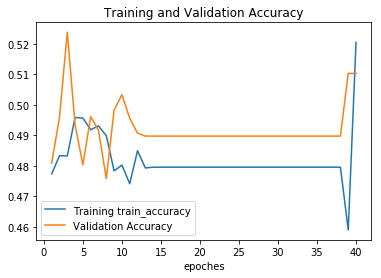

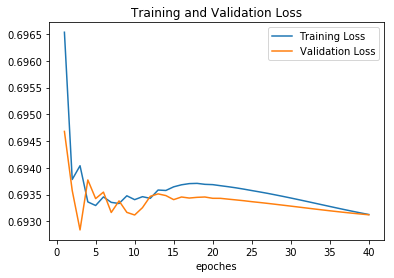

In [24]:
dianostic_plots(train_acc_list[::5], train_loss_list[::5], val_acc_list, val_loss_list)